# Hazardous Ingredients in Cosmetics Project

This project contains data from the California Department of Public Health where they maintain a database of all personal beauty products that contain ingredients that could potentially be hazardous. All products are self-reported by the manufacturers or companies, and reporting is required if the company:

   * Has annual aggregate sales of cosmetic products of one million dollars or more, and
   * Has sold cosmetic products in California on or after January 1, 2007.
   
Additional data from Kaggle was added to ensure that products that do not contain a hazardous ingredient are included in the project.

## Goals:
   * Determine features that could determine whether a product will contain a hazardous ingredient.
   * Build a model that can accurately predict if a product contains a hazardous ingredient.

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
from scipy import stats


from sklearn.model_selection import train_test_split
import sklearn.preprocessing
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

import category_encoders as ce
import prepare as prep

## Acquire
* Data acquired from California Department of Public Health (CDPH) and Kaggle.com
* Two separate dataframes are acquired before cleaning
    * DF1, the data from Kaggle, has 11 columns and 1472 rows before cleaning
    * DF2, the data from CDPH, has 22 columns and 114635 rows before cleaning
* Each row is a single product
* Each column contains information about the product

## Prepare
DF1 (Kaggle):
* Duplicates removed
* Ingredients extracted from single cell
* Target column, has_hazard_ingredient, created when comparing ingredients to hazard ingredient list.
* Unused columns dropped
* Product types renamed to match CHDP data.
    * Only Skincare products and Sunscreen products
* Columns renamed to match CDHP data.

DF2 (CDPH):
* Duplicates removed
* Target column, has_hazard_ingredient, created
* Unused columns dropped
* Columns renamed

Final dataframe:
* Combined Kaggle and CDPH dataframes
* All other types of products other than Skincare and Sunscreen removed:
    * These two types were the only ones that contained products with non-hazardous ingredients
* Split the data into train, validate, split in a 50, 30, 20 split, stratified on has_hazard_ingredient.
* 'Brand' and 'Type' features encoded:
    * LeaveOneOut Encoding used for dimensionality issues with a sigma = 0.5 to avoid overfitting.
        * Target excluded in test data
* Final dataframe has 4 columns and 7193 rows.

In [2]:
# acquire
df1, df2 = prep.get_cosmetic_data()

## Before we clean it up, let's see some interesting numbers from the CDHP database:

In [3]:
#top 5 hazardous chemicals products
df2.ChemicalName.value_counts().sort_values(ascending=False).head(5)

Titanium dioxide                                                                                       93480
Silica, crystalline (airborne particles of respirable size)                                             2817
Retinol/retinyl esters, when in daily dosages in excess of 10,000 IU, or 3,000 retinol equivalents.     2154
Mica                                                                                                    1919
Butylated hydroxyanisole                                                                                1888
Name: ChemicalName, dtype: int64

In [4]:
#list of 10 companies with the most products with hazardous ingredients
df2.CompanyName.value_counts().sort_values(ascending=False).head(10)

L'Oreal USA                            5747
S+                                     5165
Coty                                   5162
Revlon Consumer Product Corporation    4341
Bare Escentuals Beauty, Inc.           3828
The Procter & Gamble Company           3535
NYX Los Angeles, Inc.                  3227
Charlotte Tilbury Beauty Ltd           2770
Tarte Cosmetics                        2497
Victoria's Secret Beauty               2219
Name: CompanyName, dtype: int64

In [5]:
#list of 10 brands with the most products with hazardous ingredients
df2.BrandName.value_counts().sort_values(ascending=False).head(9)

SEPHORA                     3394
NYX                         3227
bareMinerals                3158
Charlotte Tilbury           2453
Revlon                      2335
NARS                        2185
Victoria's Secret Beauty    2106
tarte                       2101
Sally Hansen                1834
Name: BrandName, dtype: int64

In [6]:
# clean the first df
df1, df2 = prep.prep_df1(df1,df2)

#clean the second df
df2 = prep.prep_df2(df2)

#clean the final df
df = prep.final_prep(df1,df2)

In [7]:
#split the data
train, validate, test = prep.train_validate_test_split(df, 'has_hazard_ingredient', seed=611)

## Explore

### What portion of products contain hazardous materials?

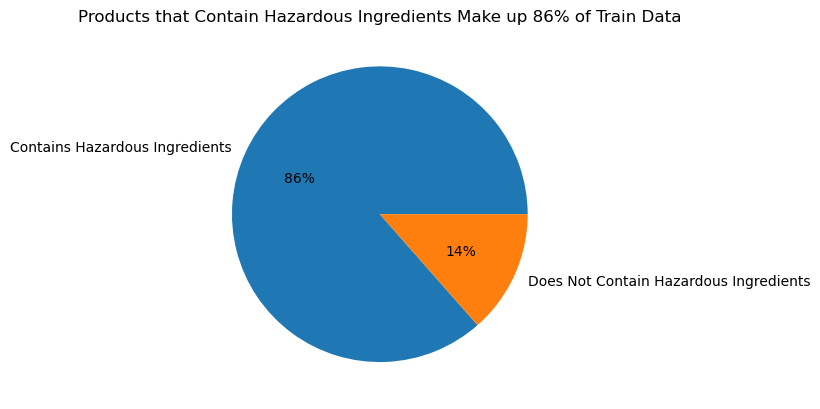

In [8]:
# visualize hazardous ingredients
labels = ['Contains Hazardous Ingredients', 'Does Not Contain Hazardous Ingredients']
plt.pie(train.has_hazard_ingredient.value_counts(), labels=labels, autopct='%.0f%%')
plt.title("Products that Contain Hazardous Ingredients Make up 86% of Train Data")
plt.show()

### Are some product types more likely to have hazardous ingredients?

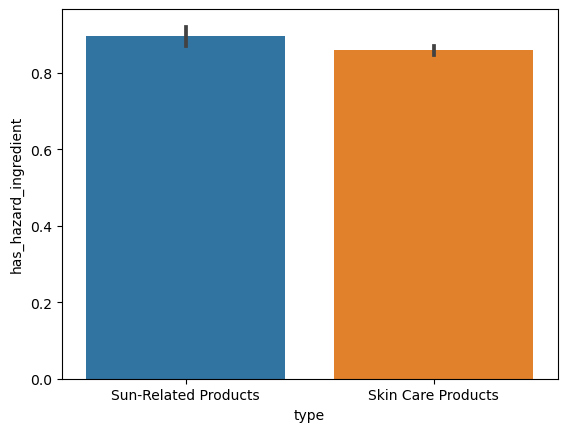

In [9]:
plt.title("")
sns.barplot(x="type", y="has_hazard_ingredient", data=train) 
plt.show()

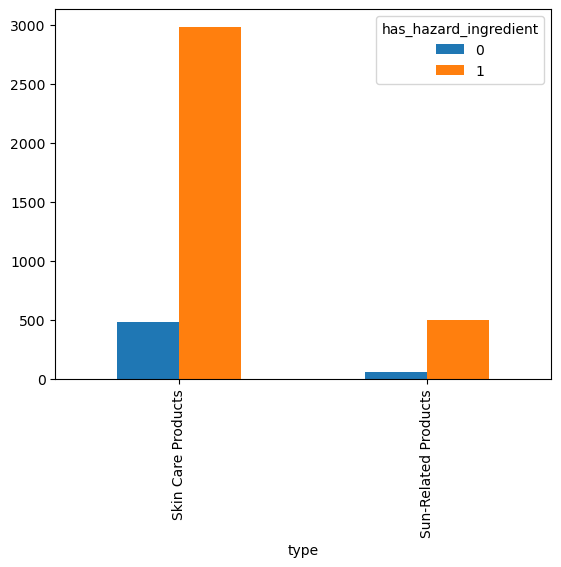

In [10]:
# create a crosstab between contract type and churn

contract_crosstab = pd.crosstab(index=train['type'], columns=train['has_hazard_ingredient'])

# visualize contract_type and churn

contract_crosstab.plot.bar()
plt.title("")
plt.show()

In [11]:
# Let's run a chi squared to compare proportions, to have more confidence
alpha = 0.05
null_hypothesis = "hazardous ingredient and product type are independent"
alternative_hypothesis = "there is a relationship between hazardous ingredient and product type"

# Setup a crosstab of observed survival to pclass
observed = pd.crosstab(train.has_hazard_ingredient, train.type)

chi2, p, degf, expected = stats.chi2_contingency(observed)

if p < alpha:
    print("Reject the null hypothesis that", null_hypothesis)
    print("Sufficient evidence to move forward understanding that", alternative_hypothesis)
else:
    print("Fail to reject the null")
    print("Insufficient evidence to reject the null")
p


Reject the null hypothesis that hazardous ingredient and product type are independent
Sufficient evidence to move forward understanding that there is a relationship between hazardous ingredient and product type


0.023290619948187798

### Are certain skincare brands more likely to have hazardous ingredients?

In [12]:
skincare_only = train[train.type == 'Skin Care Products' ]

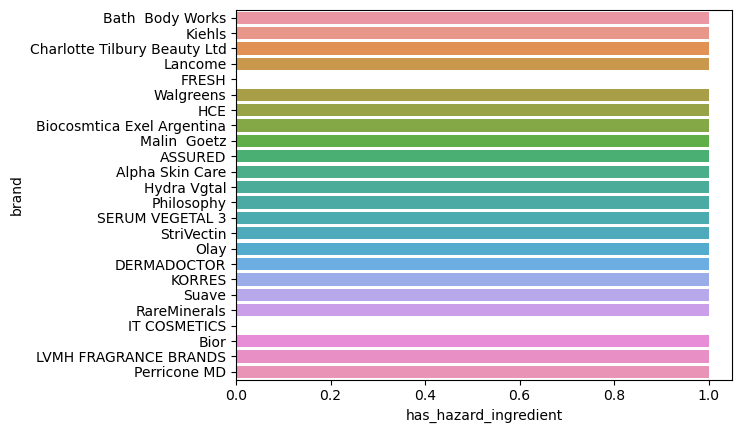

In [13]:
plt.title("")
sns.barplot(y="brand", x="has_hazard_ingredient", data=skincare_only.sample(n=25)) 
plt.show()

### Are certain suncare brands more likely to have hazardous ingredients?

In [14]:
suncare_only = train[train.type == 'Sun-Related Products' ]

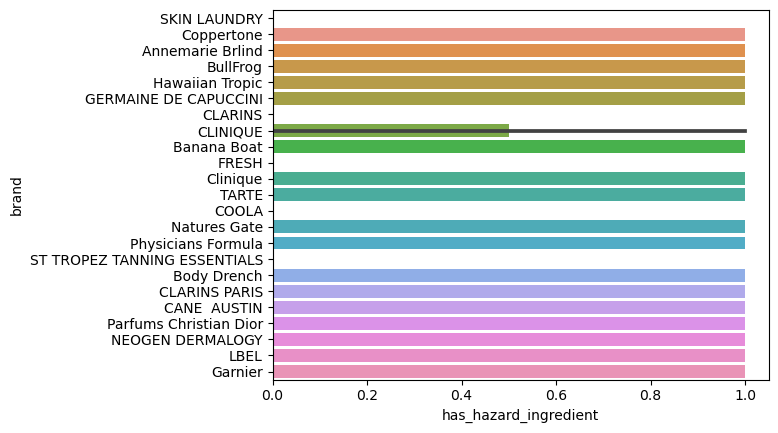

In [15]:
plt.title("")
sns.barplot(y="brand", x="has_hazard_ingredient", data=suncare_only.sample(n=25)) 
plt.show()

In [16]:
# Let's run a chi squared to compare proportions, to have more confidence
alpha = 0.05
null_hypothesis = "hazardous ingredient and brand are independent"
alternative_hypothesis = "there is a relationship between hazardous ingredient and brand"

# Setup a crosstab of observed survival to pclass
observed = pd.crosstab(train.has_hazard_ingredient, train.brand)

chi2, p, degf, expected = stats.chi2_contingency(observed)

if p < alpha:
    print("Reject the null hypothesis that", null_hypothesis)
    print("Sufficient evidence to move forward understanding that", alternative_hypothesis)
else:
    print("Fail to reject the null")
    print("Insufficient evidence to reject the null")
p


Reject the null hypothesis that hazardous ingredient and brand are independent
Sufficient evidence to move forward understanding that there is a relationship between hazardous ingredient and brand


1.0236544282439081e-204

## Modeling

In [17]:
#prepare data for modeling
X_train, y_train, X_val, y_val, X_test, y_test = prep.encode_df(train,validate,test)

In [18]:
#Results
prep.model_results(X_train, y_train, X_val, y_val)

Accuracy of Decision Tree classifier on training set: 0.89
Accuracy of Decision Tree classifier on validate set: 0.88


Accuracy of random forest classifier on training set: 0.87
Accuracy of random forest classifier on validate set: 0.87


Accuracy of KNN classifier on training set: 0.91
Accuracy of KNN classifier on validate set: 0.87


Accuracy of Logistic Regression classifier on training set: 0.86
Accuracy of Logistic Regression classifier on validate set: 0.86


### Final test - Decision Tree

In [19]:
# accuracy of dt on test data
prep.final_model(X_train, y_train,X_test, y_test)

Accuracy of Decision Tree classifier on test set: 0.89


# Recommendations
* Continue developing the model.
    * Data too specified for accurate work in real world application

## Next Steps
Find more data.
   * Lack of products that don't contain hazard ingredients skewed the data
  
Features:

   * keep ingredients that aren't listed as hazardous
   * country the product is manufactured
    
Encoding:

   * Explore further encoding methods that can handle dimensionality (thousands of brands) without overfitting model on a binary target value (bayesian methods?)